Epoch 0: Loss = 10.502275
Epoch 200: Loss = 0.037472
Epoch 400: Loss = 0.024590
Epoch 600: Loss = 0.011846
Epoch 800: Loss = 0.002227


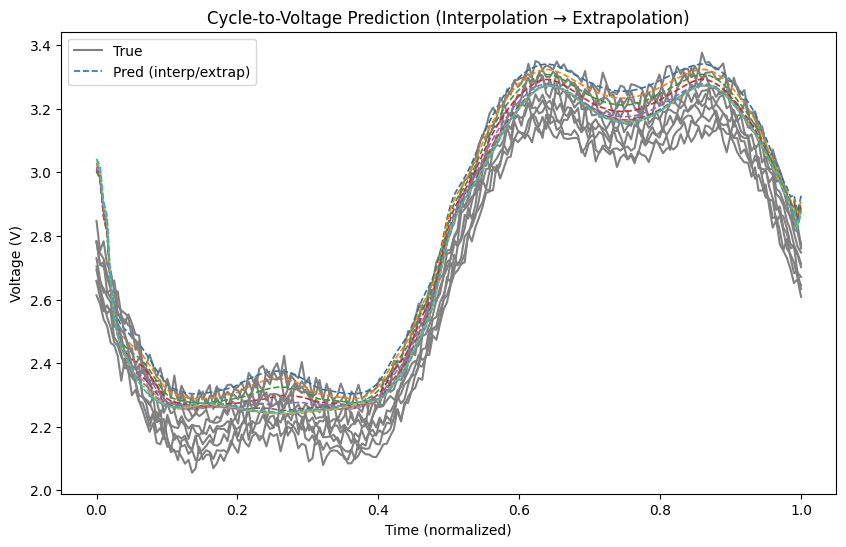

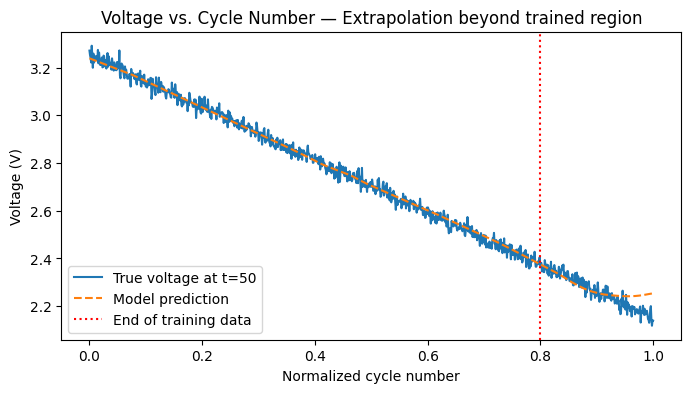

In [1]:

# ========================================
# ⚡ Current → Voltage Neural Net (Interpolation & Extrapolation)
# ========================================
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(0)

# --- 1️⃣ Generate synthetic data ---
n_cycles = 800          # training cycles (0–0.8 normalized)
n_test_cycles = 1000    # total (includes extrapolation)
seq_len = 200           # samples per cycle

# Generate synthetic "current" waveforms
t = torch.linspace(0, 1, seq_len)
base_current = torch.sin(2 * torch.pi * t) * 2 + 0.5 * torch.sin(6 * torch.pi * t)

def generate_voltage(i_t, cycle):
    """Synthetic voltage model: degrades over cycles."""
    decay = 1 - 0.3 * cycle    # fade factor
    ir_drop = 0.1 * (1 + 0.5 * cycle)
    noise = 0.02 * torch.randn_like(i_t)
    return decay * (3.7 - 0.2 * i_t) - ir_drop * i_t + noise

# Generate dataset
cycles = torch.linspace(0, 1, n_test_cycles)
currents = base_current.repeat(n_test_cycles, 1)
voltages = torch.stack([generate_voltage(currents[i], cycles[i]) for i in range(n_test_cycles)])

# Split train/test
train_idx = torch.arange(0, int(0.8 * n_test_cycles))
test_idx = torch.arange(int(0.8 * n_test_cycles), n_test_cycles)
curr_train, volt_train, cyc_train = currents[train_idx], voltages[train_idx], cycles[train_idx]
curr_test, volt_test, cyc_test = currents[test_idx], voltages[test_idx], cycles[test_idx]

# --- 2️⃣ Define model ---
class CurrentToVoltageNet(nn.Module):
    def __init__(self, in_channels=2, hidden_channels=64, n_layers=4):
        super().__init__()
        layers = []
        ch = in_channels
        for _ in range(n_layers):
            layers += [nn.Conv1d(ch, hidden_channels, 5, padding=2), nn.ReLU()]
            ch = hidden_channels
        self.conv = nn.Sequential(*layers)
        self.out = nn.Conv1d(hidden_channels, 1, 1)
    def forward(self, x):
        return self.out(self.conv(x))

model = CurrentToVoltageNet()
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# --- 3️⃣ Training ---
n_epochs = 1000
for epoch in range(n_epochs):
    # Batch all data (small synthetic set)
    cycle_scaled = cyc_train.unsqueeze(1).unsqueeze(2).expand(-1, seq_len, 1)
    inp = torch.cat([curr_train.unsqueeze(2), cycle_scaled], dim=2).permute(0, 2, 1)
    y_true = volt_train.unsqueeze(1)
    opt.zero_grad()
    pred = model(inp)
    loss = loss_fn(pred, y_true)
    loss.backward()
    opt.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# --- 4️⃣ Evaluate across interpolation & extrapolation ---
preds = []
for i in range(len(cyc_test)):
    cnum = cyc_test[i].item()
    inp = torch.cat([
        curr_test[i].unsqueeze(1),
        torch.full_like(curr_test[i].unsqueeze(1), cnum)
    ], dim=1).permute(1, 0).unsqueeze(0)
    preds.append(model(inp).squeeze().detach())
preds = torch.stack(preds)

# --- 5️⃣ Visualization ---
fig, ax = plt.subplots(figsize=(10, 6))
for i, cyc in enumerate(cyc_test[::20]):
    ax.plot(t, volt_test[::20][i], color='gray', lw=1.5, label='True' if i == 0 else "")
    ax.plot(t, preds[::20][i], '--', lw=1.2,
            label='Pred (interp/extrap)' if i == 0 else "")

ax.set_title("Cycle-to-Voltage Prediction (Interpolation → Extrapolation)")
ax.set_xlabel("Time (normalized)")
ax.set_ylabel("Voltage (V)")
ax.legend()
plt.show()

# --- 6️⃣ Visualize trend at a single point in time ---
time_index = 50  # pick one time sample
true_vs_cycle = voltages[:, time_index]
pred_vs_cycle = []
for cnum in cycles:
    inp = torch.cat([
        base_current.unsqueeze(1),
        torch.full_like(base_current.unsqueeze(1), cnum)
    ], dim=1).permute(1, 0).unsqueeze(0)
    pred_vs_cycle.append(model(inp).squeeze()[time_index].item())

plt.figure(figsize=(8,4))
plt.plot(cycles, true_vs_cycle, label="True voltage at t=50")
plt.plot(cycles, pred_vs_cycle, '--', label="Model prediction")
plt.axvline(0.8, color='r', linestyle=':', label="End of training data")
plt.title("Voltage vs. Cycle Number — Extrapolation beyond trained region")
plt.xlabel("Normalized cycle number")
plt.ylabel("Voltage (V)")
plt.legend()
plt.show()
